In [1]:
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from tqdm.notebook import tqdm


In [2]:
data =pd.read_csv('AirPassengers.csv')
data['Month'] = pd.to_datetime(data['Month'], format='%Y-%m')
data = data.set_index('Month')


In [3]:
data

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


Text(0.5, 1.0, 'Airline passenger traffic')

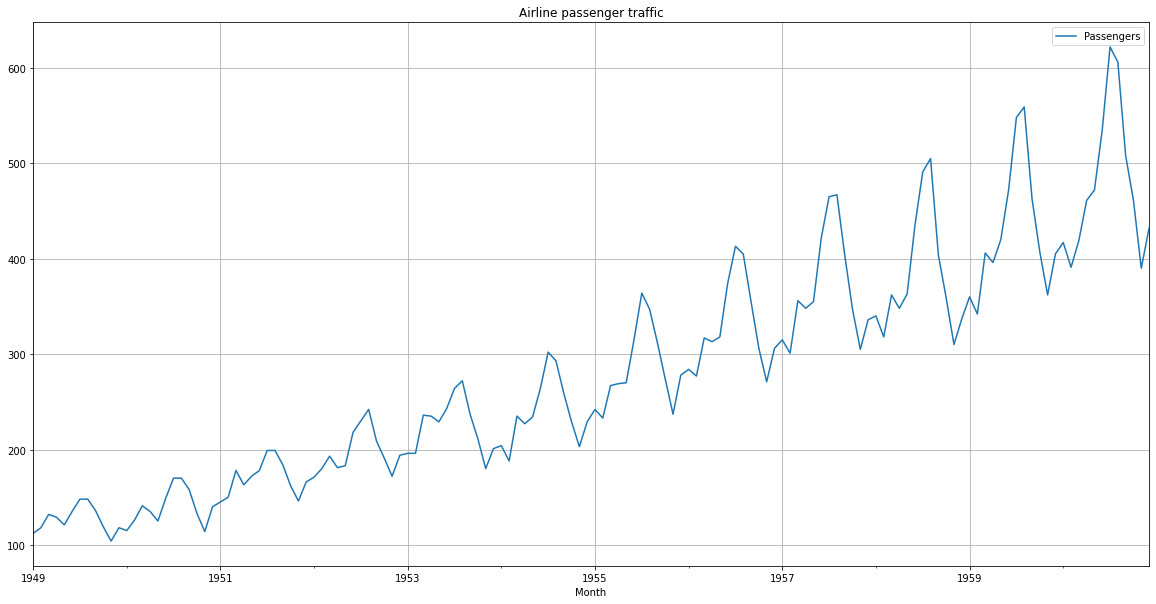

In [4]:
data.plot(figsize=(20, 10))
plt.grid()
plt.legend(loc='best')
plt.title('Airline passenger traffic')

C:\Users\rahul\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\rahul\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\rahul\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.co

<Figure size 432x288 with 0 Axes>

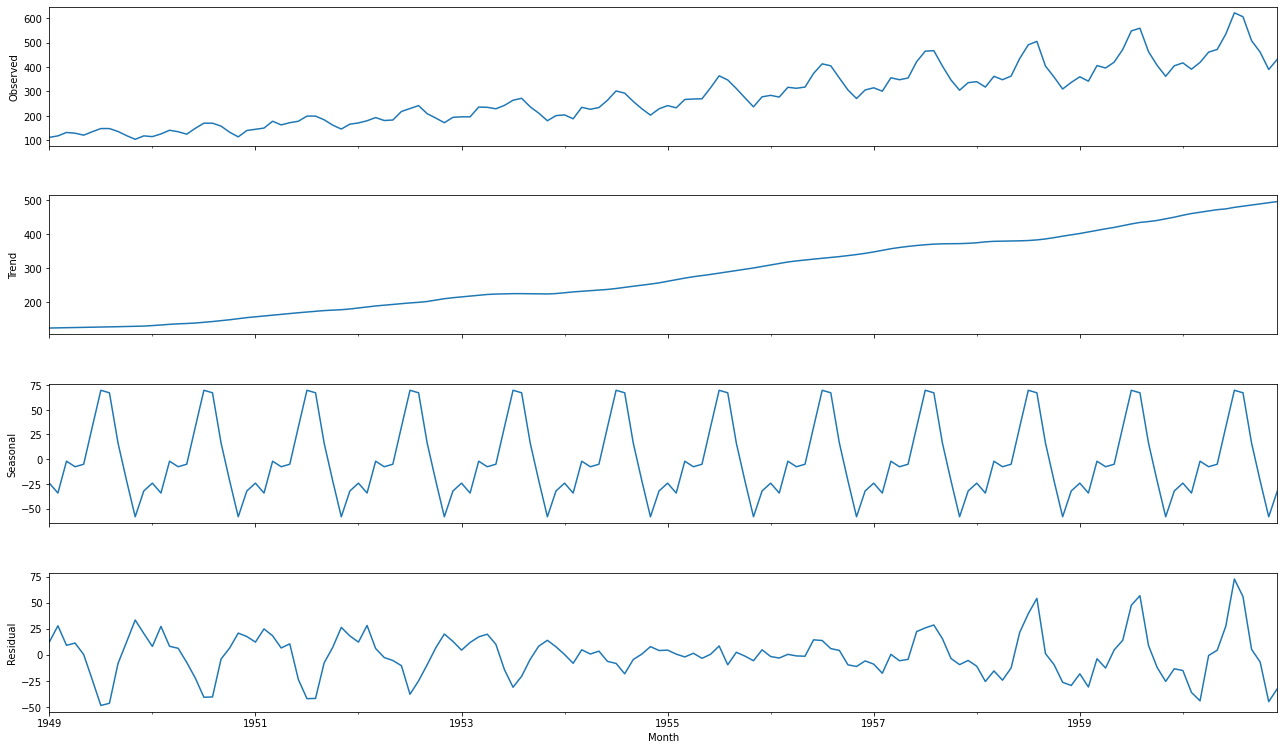

In [5]:
decomposition = seasonal_decompose(data.Passengers, freq=12,
extrapolate_trend = 1)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(20, 12)


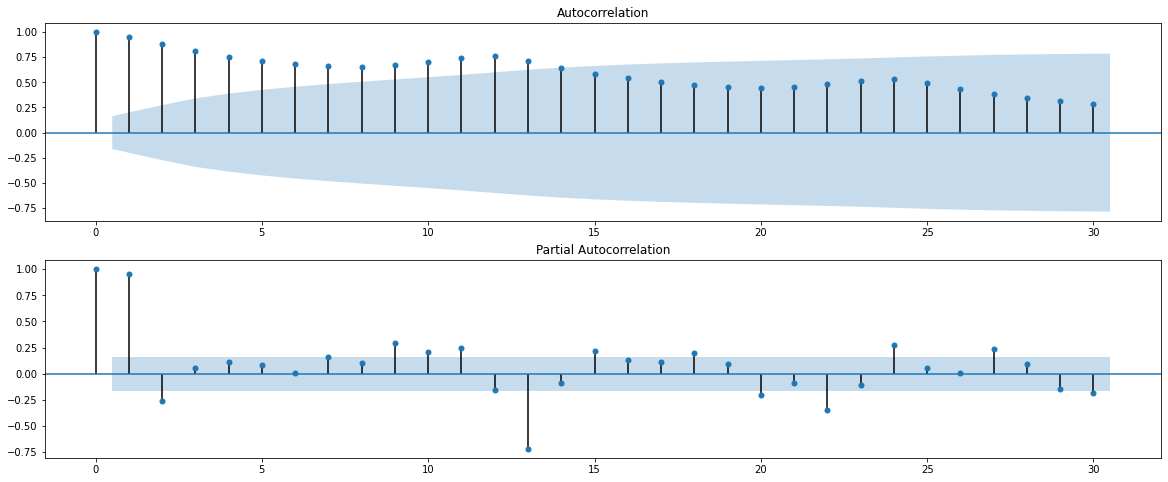

In [6]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data.Passengers.iloc[:], lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data.Passengers.iloc[:], lags=30, ax=ax2)

In [7]:
def dicky_fuller_test(timeseries):
 print('Results of Dickey-Fuller Test:')
 dftest = adfuller(timeseries)
 dfoutput = pd.Series(dftest[0:4],
 index=['TestStatistic','p-value','#Lags Used','Number of Observations Used'])
 for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
 print(dfoutput)

In [8]:
data['Passengers'] = np.log(data['Passengers'])
data['first_difference'] = data.Passengers - data.Passengers.shift()

Text(0.5, 1.0, 'Log Difference of Airline passenger traffic')

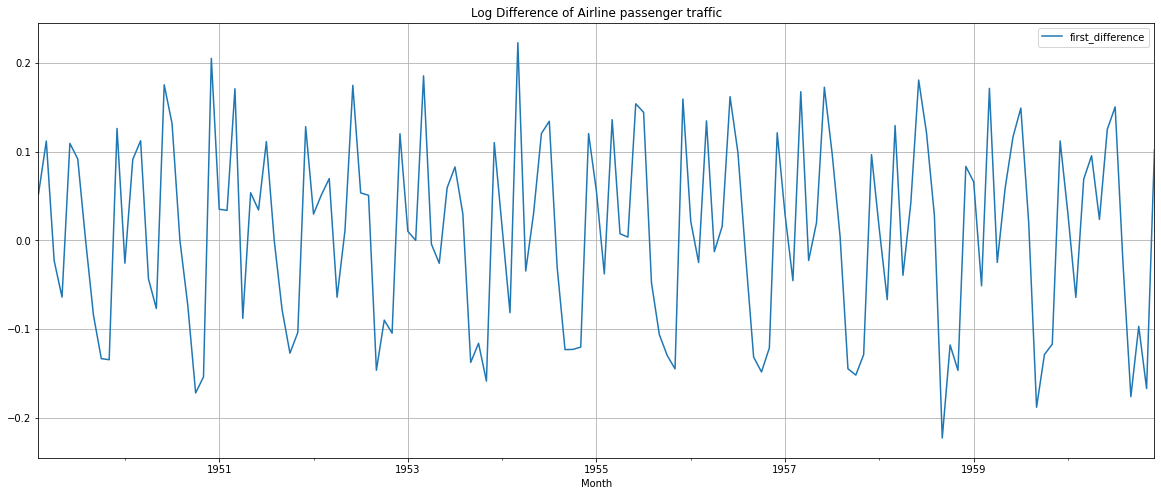

In [9]:
data.first_difference.dropna(inplace=False).plot(figsize=(20, 8))
plt.grid()
plt.legend(loc='best')
plt.title('Log Difference of Airline passenger traffic')


In [10]:
data['seasonal_difference'] = data.first_difference -data.first_difference.shift(12)


Text(0.5, 1.0, 'Log difference and seasonal differnce of Airline passenger traffic')

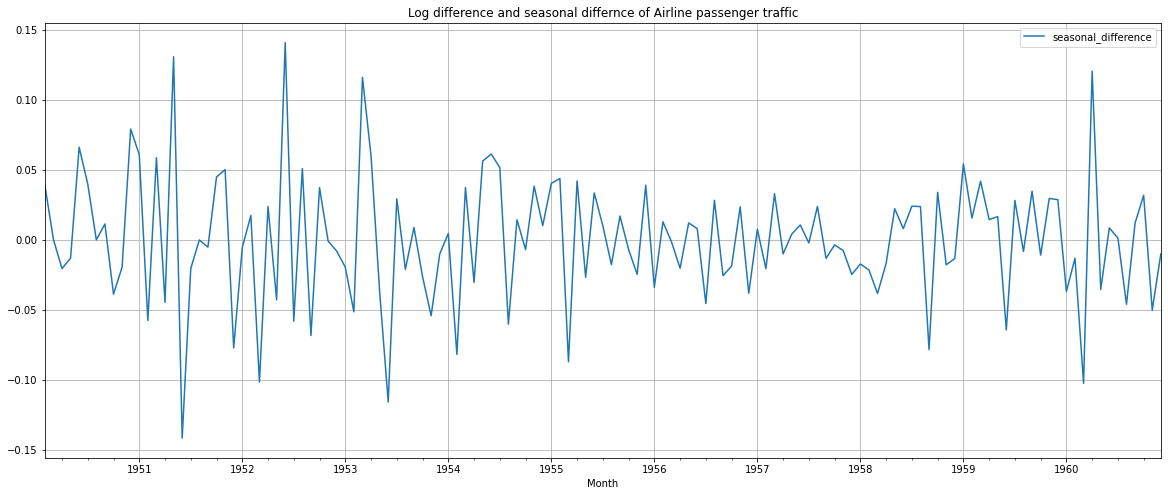

In [11]:
data.seasonal_difference.dropna(inplace=False).plot(figsize=(20, 8))
plt.grid()
plt.legend(loc='best')
plt.title('Log difference and seasonal differnce of Airline passenger traffic')


In [12]:
dicky_fuller_test(data.seasonal_difference.dropna(inplace=False))

Results of Dickey-Fuller Test:
TestStatistic                   -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


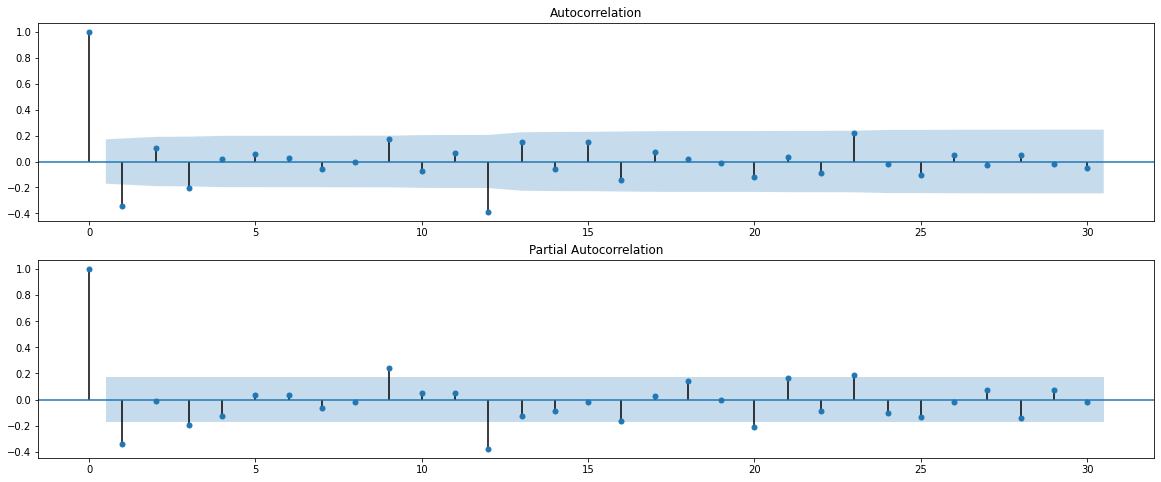

In [13]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data['seasonal_difference'].iloc[13:],
lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data['seasonal_difference'].iloc[13:],
lags=30, ax=ax2)

In [14]:
model = SARIMAX(data.Passengers, order=(1, 1, 1), seasonal_order=(1, 1, 1,
12))
model_fit = model.fit()


C:\Users\rahul\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [15]:
y_hat_sarima = data['first_difference'].copy()
y_hat_sarima['sarima_forecast_tmp'] = model_fit.predict(data['first_difference'].index.min(),
data['first_difference'].index.max())
y_hat_sarima['sarima_forecast'] =np.exp(y_hat_sarima['sarima_forecast_tmp'])

Text(0.5, 1.0, 'Seasonal autoregressive integrated moving average (SARIMA) method')

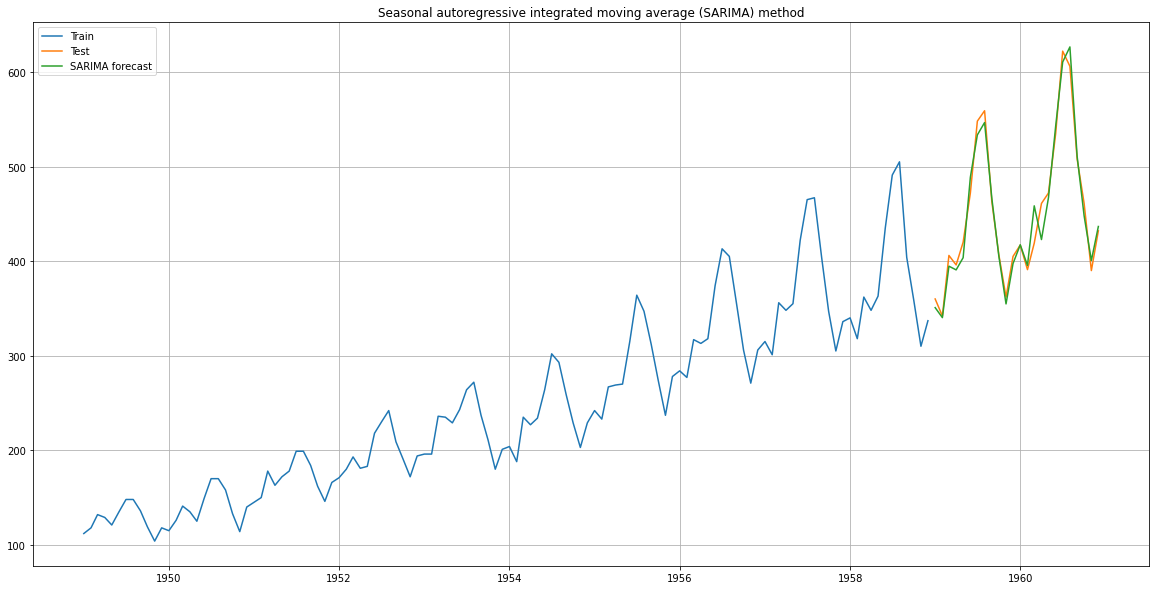

In [16]:
plt.figure(figsize=(20,10))
plt.grid()
plt.plot(np.exp(data.Passengers[:120]), label='Train')
plt.plot(np.exp(data.Passengers[120:]), label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][data.Passengers[120:].index.min():], label='SARIMA forecast')
plt.legend(loc='best')
plt.title('Seasonal autoregressive integrated moving average (SARIMA) method')

In [17]:
best_model = SARIMAX(data['Passengers'], order=(1, 1, 1),
seasonal_order=(1, 1, 1, 12)).fit(dis=-1)
print(best_model.summary())

C:\Users\rahul\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                         Passengers   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 245.152
Date:                            Sun, 06 Dec 2020   AIC                           -480.304
Time:                                    16:11:26   BIC                           -465.928
Sample:                                01-01-1949   HQIC                          -474.462
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1663      0.213      0.781      0.435      -0.251       0.583
ma.L1         -0.5612      0.185   

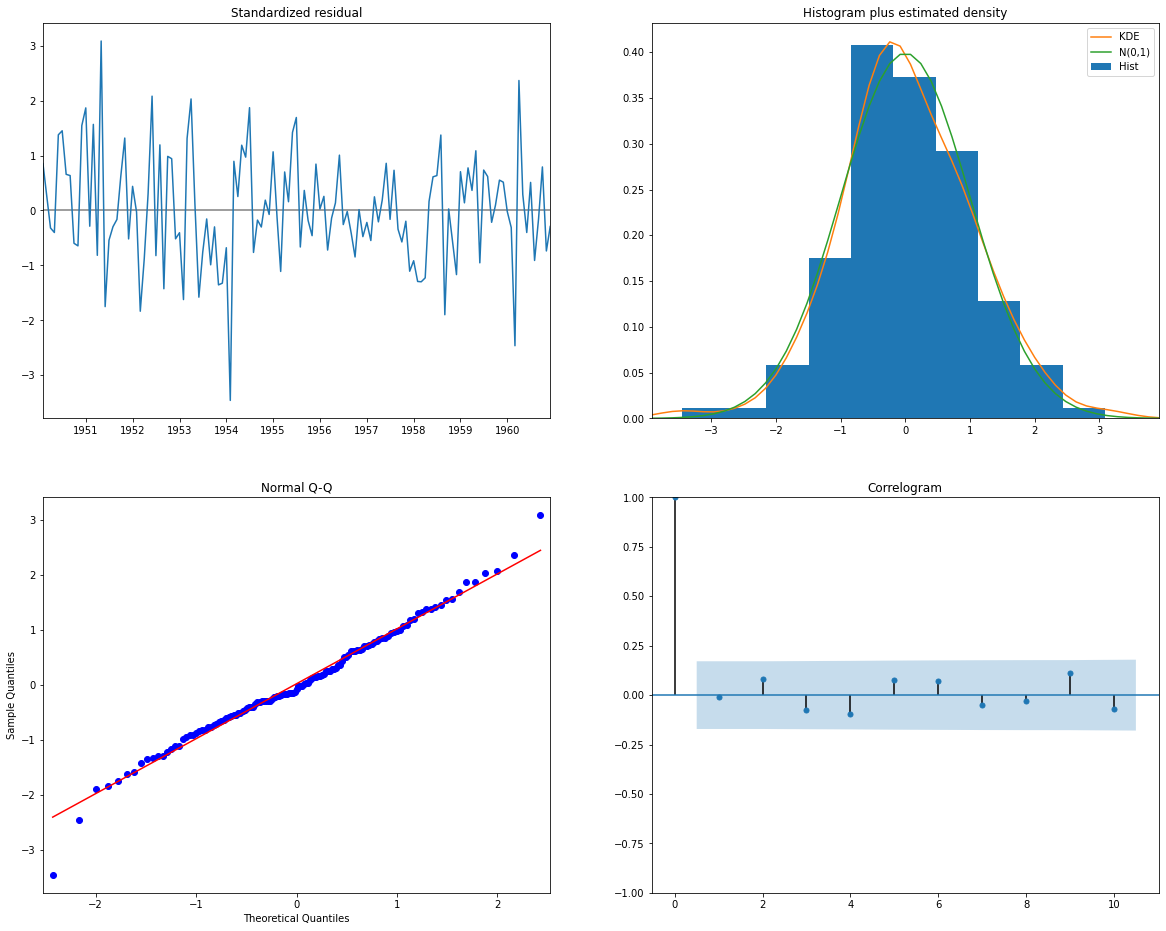

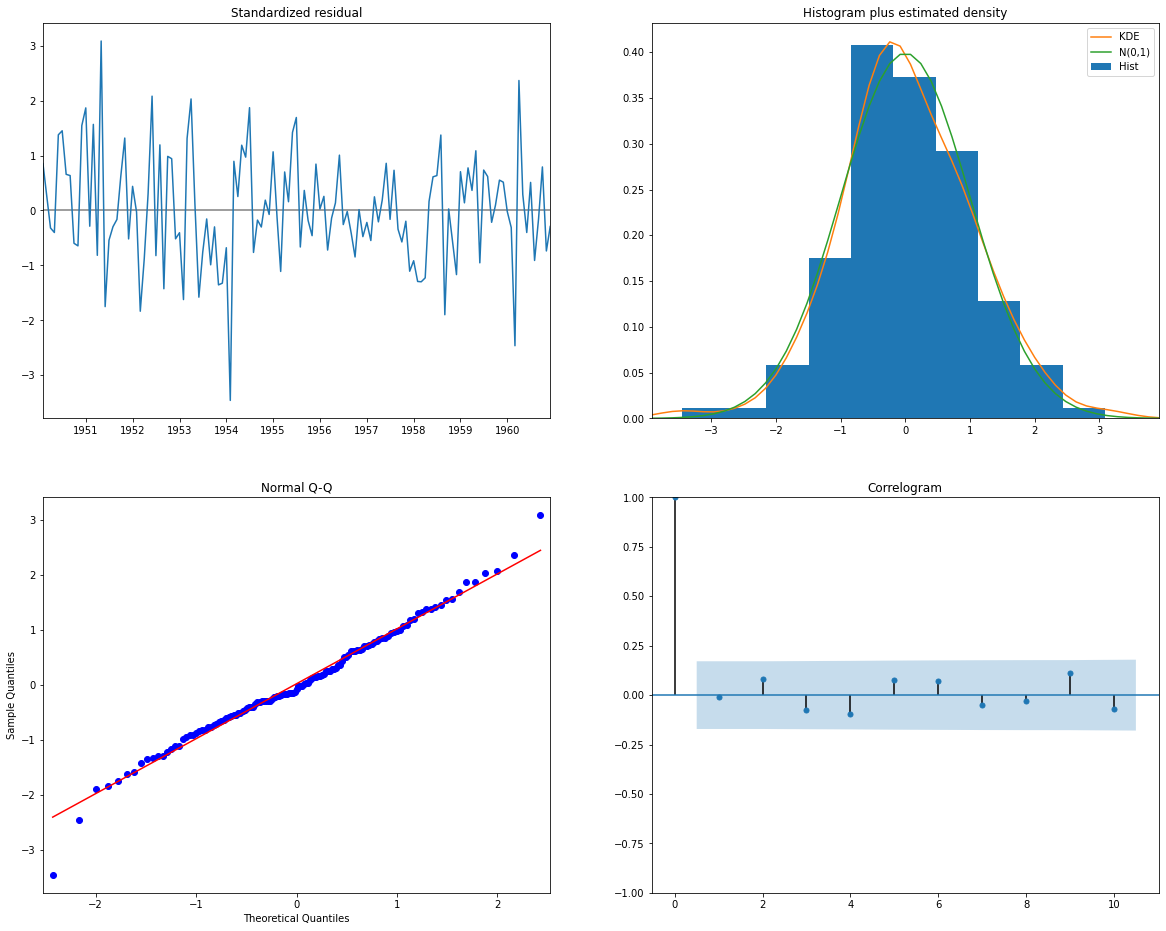

In [18]:
best_model.plot_diagnostics(figsize=(20, 16))